In [41]:
library(rgdal)
library(dplyr)
library(tmap)
library(cartogram)
library(tmaptools)
library(OpenStreetMap)

Warning message:
"package 'tmaptools' was built under R version 3.4.2"Warning message:
"package 'OpenStreetMap' was built under R version 3.4.3"

OGR data source with driver: ESRI Shapefile 
Source: "C:\Users\Joy Basford\Desktop\statistical-gis-boundaries-london\ESRI", layer: "London_Borough_Excluding_MHW"
with 33 features
It has 7 fields


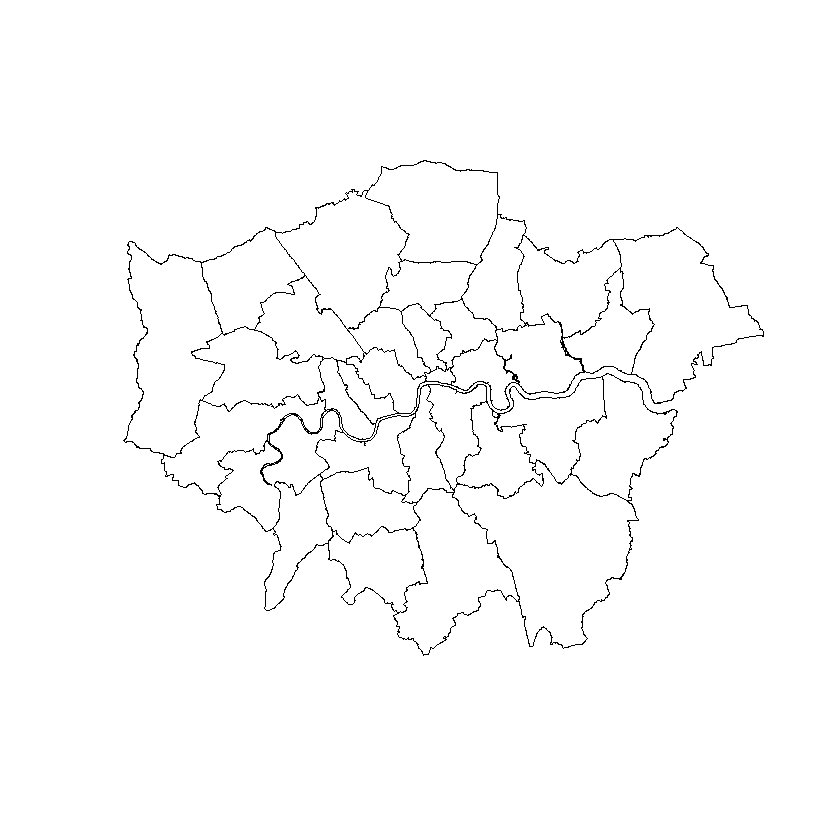

In [3]:
# we use readOGR to call the London Borough shapefiles and assign it to to 'ldn'
# we can check how it looks by plotting it.
ldn <- readOGR(dsn = "C:\\Users\\Joy Basford\\Desktop\\statistical-gis-boundaries-london\\ESRI", layer = "London_Borough_Excluding_MHW")
plot(ldn)

In [4]:
# Let's also check the number of boroughs using nrow()
nrow(ldn)

[1] 33

In [18]:
# Now let's load data from the borough surveys. 
# We'll want to merge this with the borough shapefiles.

data<- read.csv("C:\\Users\\Joy Basford\\Desktop\\data.csv", stringsAsFactors = FALSE)

In [23]:
# To merge the two files, we will need to find a column in common, in this case what we want is to use the name of the borough.
# We can open the files in RStudio environment to see how the data looks.
# It appears we'll need to merge column 'NAME' in the shapefiles and column 'ï..borough' in the data.csv. 
# Merge the files using left_join().

ldn@data <- left_join(ldn@data, data, by = c('NAME' = 'ï..borough'))

Warning message:
"Column `NAME`/`Ã¯..borough` joining factor and character vector, coercing into character vector"

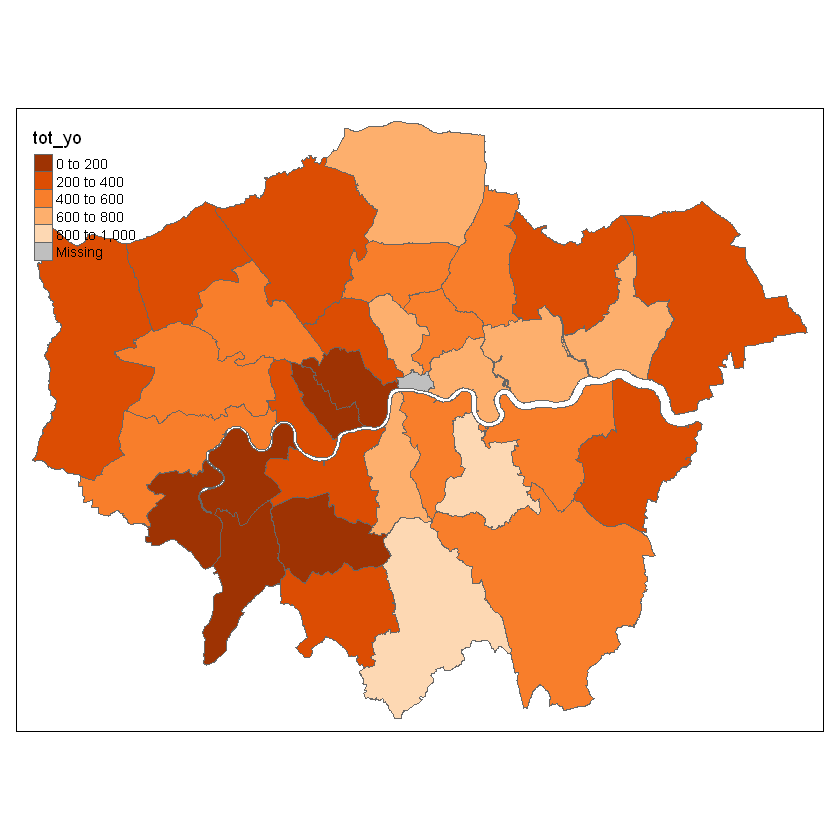

In [45]:
# Now you can fill in the shapefile boundaries with the values from your data columns using qtm()
# qtm is part of the TMAP library and nifty for a quick map view of the data
# Below, I'm looking to compare total offences committed in FY2015, using a pre-defined palette.

qtm(ldn, fill = c("tot_yo"), fill.palette = "-Oranges")

In [37]:
# One problem of displaying data this way is that larger boroughs are more prominent, visually,
# and might seem to have more issues. A cartogram is a nice way to address this, as it redefines the borough areas
# according to the proportion of crime data they have.

# Create the cartogram layer, referencing the column you want to investigate, here 'Total Offences'.
data_carto <- cartogram(ldn, "tot_yo", itermax=5)


Warning message in cartogram(ldn, "tot_yo", itermax = 5):
"NA not allowed in weight vector. Features will be removed from Shape."Mean size error for iteration 1: 1.97326031382789
Mean size error for iteration 2: 1.60028419503806
Mean size error for iteration 3: 1.37837282009277
Mean size error for iteration 4: 1.241772138337
Mean size error for iteration 5: 1.1569061430782


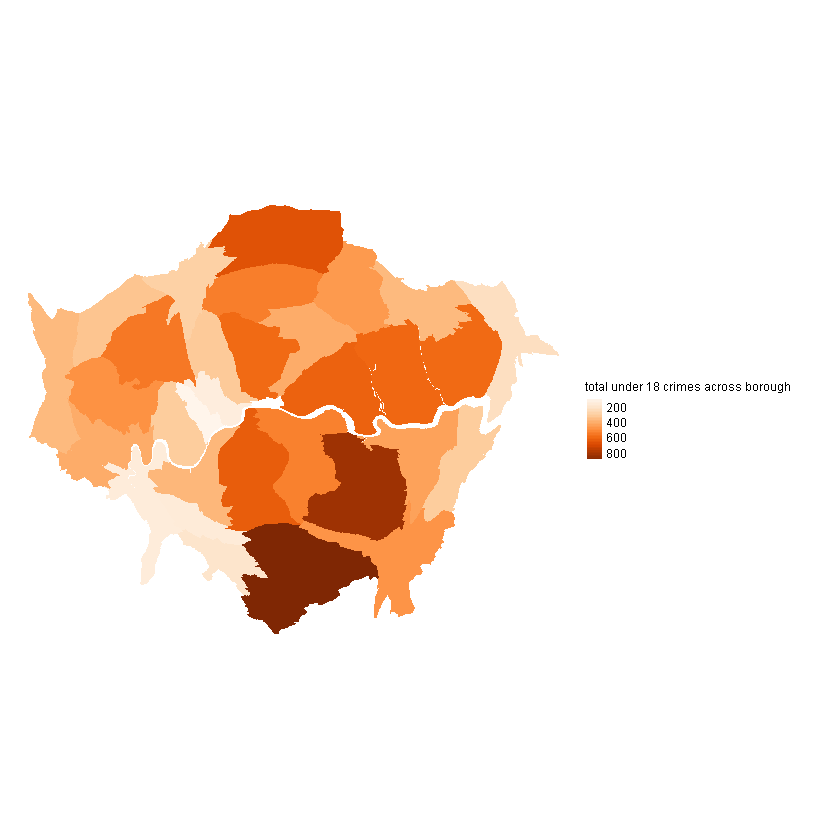

In [46]:
# Then, using tm_shape from TMAP, you can plot a transformed map by referencing 'data_carto'

tm_shape(data_carto) +  
  tm_fill(col="tot_yo",style="cont",palette="Oranges", size=0.2, id="geo_label", title="") + 
  tm_layout(
    title="total under 18 crimes across borough",
    title.snap.to.legend=TRUE,
    title.size=0.8,
    legend.text.size=0.6,
    title.position = c("right", "center"),
    legend.position = c("right","center"),
    frame=FALSE,
    legend.outside=TRUE)

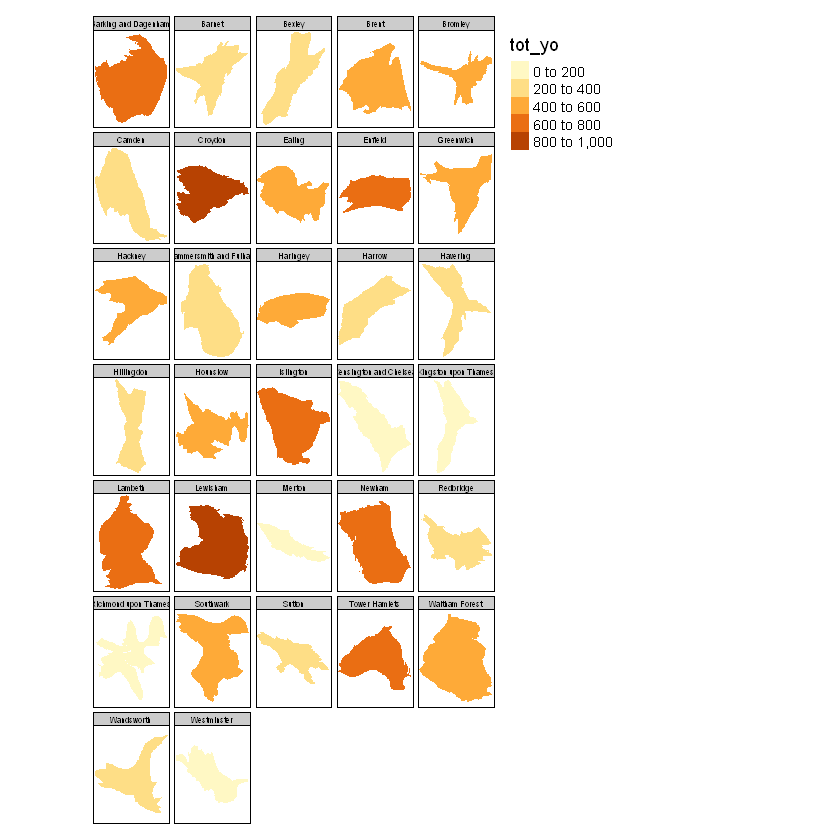

In [44]:
# You can also separate out the boroughs using tm_facts
# Chart Facets
tm_shape(data_carto) +
  tm_fill("tot_yo", thres.poly = 0) +
  tm_facets("NAME", free.coords = TRUE, drop.units = TRUE)

Warning message:
"Current projection unknown. Long lat coordinates (wgs84) assumed."

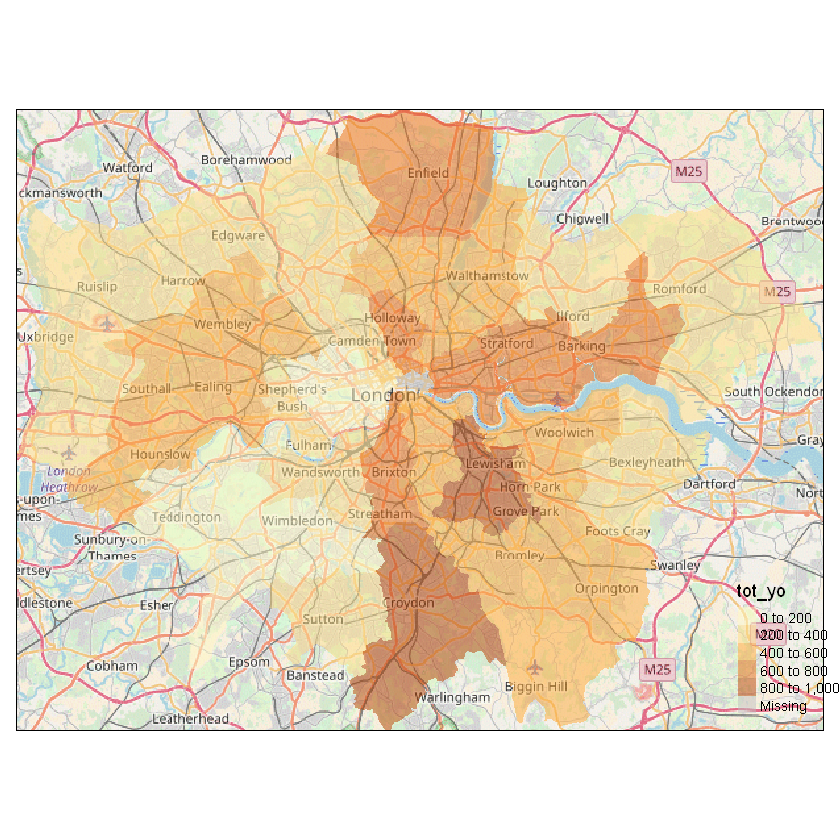

In [42]:
# You might find it useful to see these tiles in context of an Ordinance Survey map.
# For this, you'll need the tmaptools library to replace 'data_carto' in the tm_shape code. 

ldn_wgs = spTransform(ldn, CRS("+init=epsg:4326"))
osm_tiles = tmaptools::read_osm(bbox(ldn_wgs))
tm_shape(osm_tiles) + tm_raster() + tm_shape(ldn_wgs) +
  tm_fill("tot_yo", fill.title = "Crimes by Young Offenders FY2015", scale = 0.8, alpha = 0.5) + 
  tm_layout(legend.position = c(0.89,0.02))